In [ ]:
pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [1]:
import os
import time
import uuid # Uniform Unique identifier
import cv2


In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30
# Go and create Data folder and add (images, labels) folders on it

In [ ]:
# import cv2

# cap = cv2.VideoCapture(0)

# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# pip install labelme

In [ ]:
!labelme

## 2.1 Import TF and Deps

In [ ]:
pip install tensorflow

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')


[]

## 2.3 Load Image into TF Data Pipeline


In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [9]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

## 2.4 View Raw Images with Matplotlib


In [7]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## 3. Partition Unaugmented Data


In [ ]:
90*.7 # 63 to train


In [ ]:
90*.15 # 14 and 13 to test and val


## 3.2 Move the Matching Labels


In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [19]:
import albumentations as alb


In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [10]:
img = cv2.imread(os.path.join('data','train', 'images','0f8abedd-0dc4-11ed-b21d-9822efec1bc4.jpg'))
with open(os.path.join('data', 'train', 'labels', '0f8abedd-0dc4-11ed-b21d-9822efec1bc4.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']


[[318.98765432098764, 55.53086419753086],
 [556.0246913580247, 392.5679012345679]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[318.98765432098764, 55.53086419753086, 556.0246913580247, 392.5679012345679]

In [14]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.4984182098765432,
 0.11568930041152263,
 0.8687885802469136,
 0.8178497942386831]

## 4.4 Apply Augmentations and View Results


In [21]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes']

[(0.5044170096021947, 0.1320713305898491, 1.0, 0.881042524005487)]

In [22]:
augmented['bboxes'][0][2:]

(1.0, 0.881042524005487)

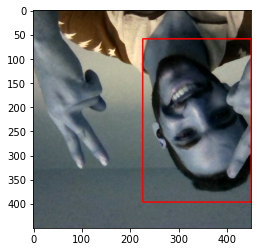

In [23]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline


## 5.1 Run Augmentation Pipeline


In [24]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6993106617647058, 0.3002450980392156, 0.4385110294117647, 0.7628676470588235, 'face'].
x_max is less than or equal to x_min for bbox [0.8398533950617283, 0.29830246913580244, 0.4887731481481481, 0.7561213991769546, 'face'].
x_max is less than or equal to x_min for bbox [0.7808823529411765, 0.22977941176470587, 0.46953125, 0.741421568627451, 'face'].
x_max is less than or equal to x_min for bbox [0.5582175925925925, 0.2700102880658436, 0.2650077160493827, 0.7972736625514403, 'face'].
x_max is less than or equal to x_min for bbox [0.8784336419753085, 0.23657407407407405, 0.5138503086419753, 0.7484053497942386, 'face'].
x_max is less than or equal to x_min for bbox [0.8919367283950617, 0.24171810699588475, 0.5331404320987654, 0.7766975308641975, 'face'].
x_max is less than or equal to x_min for bbox [0.947878086419753, 0.20570987654320985, 0.5505015432098765, 0.774125514403292, 'face'].
x_max is less than or equal to x_min for bbox [0.89579

## 5.2 Load Augmented Images to Tensorflow Dataset


In [25]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [26]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [27]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [28]:
train_images.as_numpy_iterator().next()


array([[[0.422549  , 0.36047795, 0.32463235],
        [0.47175246, 0.40900734, 0.34626225],
        [0.4392157 , 0.39607844, 0.30980393],
        ...,
        [0.4297794 , 0.4882353 , 0.5349265 ],
        [0.04448529, 0.11801471, 0.18419118],
        [0.0247549 , 0.10710784, 0.17965686]],

       [[0.36482844, 0.29362744, 0.25177696],
        [0.43737745, 0.37463236, 0.31580883],
        [0.44319853, 0.40006128, 0.32346815],
        ...,
        [0.4476103 , 0.5182598 , 0.5745098 ],
        [0.04252451, 0.12340686, 0.2052696 ],
        [0.0189951 , 0.10165441, 0.19540441]],

       [[0.36182597, 0.2863358 , 0.24957108],
        [0.42408088, 0.35931373, 0.31819853],
        [0.4574142 , 0.4060049 , 0.34454656],
        ...,
        [0.4779412 , 0.5602941 , 0.62781864],
        [0.03394608, 0.11930147, 0.20894608],
        [0.02708333, 0.12297794, 0.21280637]],

       ...,

       [[0.33382353, 0.3377451 , 0.275     ],
        [0.3151348 , 0.31905636, 0.24846813],
        [0.34270832, 0

## 6. Prepare Labels


## 6.1 Build Label Loading Function


In [29]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [30]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
# to get some images
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.192 , 0.4004, 0.584 , 0.7744], dtype=float16))

## 7.1 Check Partition Lengths


In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(1140, 1140, 300, 300, 240, 240)

## 7.2 Create Final Datasets (Images/Labels)


In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
train.as_numpy_iterator().next()[1]


(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.1499, 0.3337, 0.7383],
        [0.4692, 0.1848, 0.8916, 0.5444],
        [0.    , 0.1437, 0.444 , 0.887 ],
        [0.2058, 0.1589, 0.647 , 0.7847],
        [0.0304, 0.2181, 0.453 , 0.5776],
        [0.3171, 0.2844, 0.757 , 0.8203],
        [0.3655, 0.1707, 0.805 , 0.7065],
        [0.3206, 0.438 , 0.743 , 0.7974]], dtype=float16))

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

## 7.3 View Images and Annotations



In [37]:
data_samples = train.as_numpy_iterator()


In [38]:
res = data_samples.next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


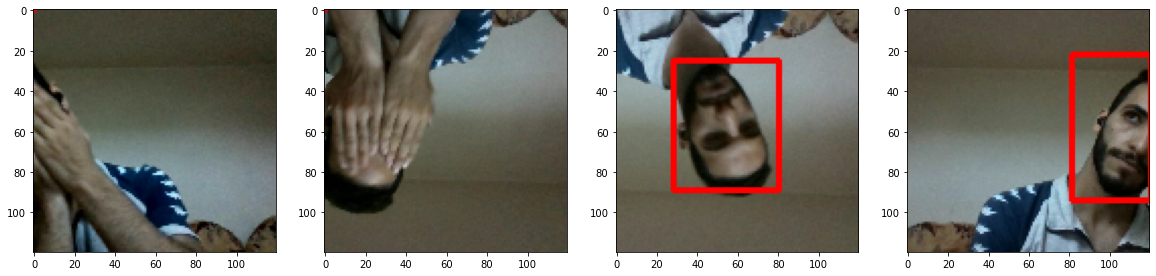

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

## 8.1 Import Layers and Base Network


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16


In [40]:
vgg = VGG16(include_top=False)
vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network


In [41]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network


In [42]:
facetracker = build_model()


In [43]:
facetracker.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [44]:
X, y = train.as_numpy_iterator().next()


In [45]:
X.shape


(8, 120, 120, 3)

In [46]:
classes, coords = facetracker.predict(X)


1/1 [==============================] - 1s 569ms/step


In [47]:
classes, coords

(array([[0.44887775],
        [0.46825743],
        [0.44259956],
        [0.45679456],
        [0.38522992],
        [0.38898668],
        [0.4593328 ],
        [0.34782943]], dtype=float32),
 array([[0.79854536, 0.5223052 , 0.7294805 , 0.42515272],
        [0.7267578 , 0.56688863, 0.6405766 , 0.43175694],
        [0.71831065, 0.55102223, 0.6589303 , 0.4432198 ],
        [0.7709025 , 0.50898945, 0.8140862 , 0.44192892],
        [0.7997154 , 0.5004913 , 0.7327814 , 0.42634988],
        [0.7547543 , 0.52697444, 0.733078  , 0.38615757],
        [0.74833924, 0.5116886 , 0.69122154, 0.44637364],
        [0.62649584, 0.48371896, 0.6555821 , 0.4352337 ]], dtype=float32))

# 9. Define Losses and Optimizers


## 9.1 Define Optimizer and LR


In [48]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


## 9.2 Create Localization Loss and Classification Loss


In [50]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [51]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics


In [52]:
localization_loss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=8.1926365>

In [53]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.7827383>

In [54]:
regressloss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=8.1926365>

# 10. Train Neural Network


## 10.1 Create Custom Model Class


In [10]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [11]:
model = FaceTracker(facetracker)


In [12]:
model.compile(opt, classloss, regressloss)


NameError: name 'opt' is not defined

## 10.2 Train


In [58]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
143/143 [==============================] - 289s 2s/step - total_loss: 0.4435 - class_loss: 0.0901 - regress_loss: 0.3984 - val_total_loss: 0.1013 - val_class_loss: 0.0038 - val_regress_loss: 0.0994
Epoch 2/10
143/143 [==============================] - 314s 2s/step - total_loss: 0.0401 - class_loss: 6.1130e-04 - regress_loss: 0.0398 - val_total_loss: 0.0919 - val_class_loss: 8.2814e-04 - val_regress_loss: 0.0915
Epoch 3/10
143/143 [==============================] - 314s 2s/step - total_loss: 0.0252 - class_loss: 1.6013e-04 - regress_loss: 0.0251 - val_total_loss: 0.0695 - val_class_loss: 8.2347e-05 - val_regress_loss: 0.0694
Epoch 4/10
143/143 [==============================] - 320s 2s/step - total_loss: 0.0236 - class_loss: 1.1827e-04 - regress_loss: 0.0235 - val_total_loss: 0.0326 - val_class_loss: 9.4833e-05 - val_regress_loss: 0.0325
Epoch 5/10
143/143 [==============================] - 328s 2s/step - total_loss: 0.0166 - class_loss: 6.6261e-05 - regress_loss: 0.0166 - va

## 10.3 Plot Performance


In [59]:
hist.history


{'total_loss': [0.07196471840143204,
  0.013191856443881989,
  0.009257516823709011,
  0.003943037241697311,
  0.00602633086964488,
  0.005680864676833153,
  0.0029179679695516825,
  0.021068209782242775,
  0.003110367339104414,
  0.0031701442785561085],
 'class_loss': [0.0005322273354977369,
  9.146085358224809e-05,
  0.0008932065102271736,
  0.0002498954418115318,
  1.9774101019720547e-05,
  8.687440640642308e-06,
  3.391621430637315e-05,
  9.849778507486917e-06,
  3.154652949888259e-05,
  1.3336710253497586e-05],
 'regress_loss': [0.07169860601425171,
  0.013146125711500645,
  0.008810913190245628,
  0.003818089608103037,
  0.006016443949192762,
  0.005676520988345146,
  0.002901009749621153,
  0.02106328494846821,
  0.003094593994319439,
  0.0031634760089218616],
 'val_total_loss': [0.10130549967288971,
  0.0918678566813469,
  0.069483682513237,
  0.03256307542324066,
  0.05332793667912483,
  0.07028341293334961,
  0.0665816143155098,
  0.07274845987558365,
  0.05729113891720772,
 

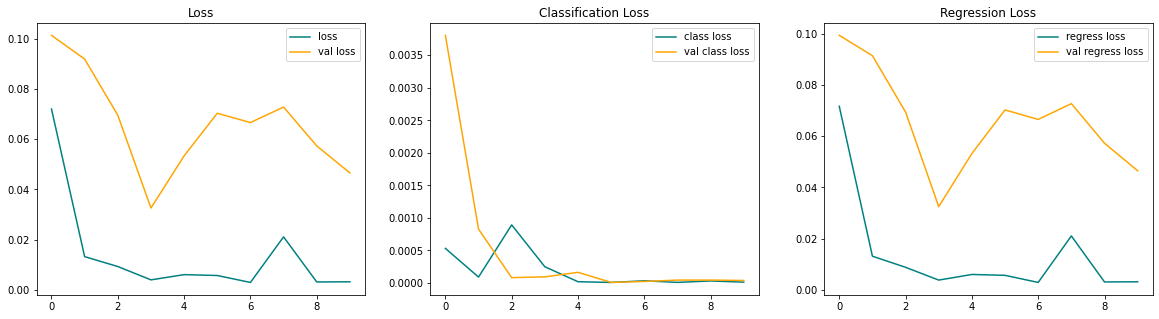

In [60]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [61]:
3*.25


0.75

# 11. Make Predictions


## 11.1 Make Predictions on Test Set


In [72]:
test_data = test.as_numpy_iterator()


In [73]:
test_sample = test_data.next()


In [74]:
yhat = facetracker.predict(test_sample[0])


1/1 [==============================] - 0s 309ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


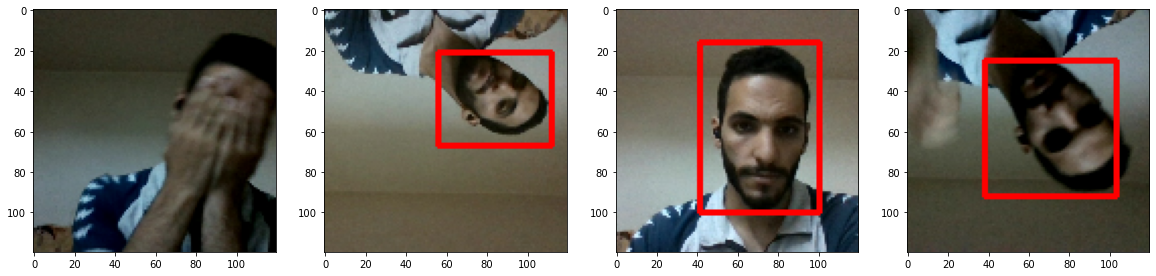

In [75]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the Model


In [3]:
from tensorflow.keras.models import load_model


In [67]:
facetracker.save('facetracker.h5')


In [4]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection


In [10]:
pip install opencv-pythonb

Note: you may need to restart the kernel to use updated packages.


In [3]:
 pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-win_amd64.whl (42.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import cv2
import tensorflow as tf

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 144ms/step


KeyboardInterrupt: 